In [ ]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF-TRT Dynamic shapes example: ResNetV2
This notebook demonstrates how to use TF-TRT dynamic shape feature to generate a single engine with multiple optimization profiles, each optimized for a different batch size.


## Requirements
This notebook requires at least TF 2.5 and TRT 7.1.3.

In [1]:
# Verbose output
# import os
# os.environ["TF_CPP_VMODULE"]="trt_engine_utils=2,trt_engine_op=2,convert_nodes=2,convert_graph=2,segment=2,trt_shape_optimization_profiles=2,trt_engine_resource_ops=2"

In [2]:
!pip install pillow matplotlib

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.framework import convert_to_constants
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from timeit import default_timer as timer

## Load and save the TF model

In [4]:
model = ResNet50V2(weights='imagenet') 
tf.saved_model.save(model, 'resnet_v2_50_saved_model')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:500: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: resnet_v2_50_saved_model/assets


## Helper functions

In [5]:
def get_func_from_saved_model(saved_model_dir):
    saved_model_loaded = tf.saved_model.load(
        saved_model_dir, tags=[tag_constants.SERVING])
    graph_func = saved_model_loaded.signatures[
        signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    return graph_func, saved_model_loaded

In [6]:
def predict_and_benchmark_throughput(batched_input, model, N_warmup_run=50, N_run=500,
                                     result_key='predictions', batch_size=None):
    elapsed_time = []
    all_preds = []
    
    if batch_size is None or batch_size > batched_input.shape[0]:
        batch_size = batched_input.shape[0]
    print('Benchmarking with batch size', batch_size)
    
    elapsed_time = np.zeros(N_run)
    for i in range(N_warmup_run):                                             
        preds = model(batched_input)
    
    # Force device synchronization
    tmp = preds[result_key][0,0].numpy() 
    
    for i in range(N_run):
        start_time = timer()
        preds = model(batched_input)
        # Synchronize
        tmp += preds[result_key][0,0].numpy() 
        end_time = timer()
        elapsed_time[i] = end_time - start_time
        all_preds.append(preds)

        if i>=50 and i % 50 == 0:
            print('Steps {}-{} average: {:4.1f}ms'.format(i-50, i, (elapsed_time[i-50:i].mean()) * 1000))

    print('Latency: {:5.2f}+/-{:4.2f}ms'.format(elapsed_time.mean()* 1000, elapsed_time.std()* 1000))
    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
    return all_preds

In [7]:
def get_dummy_images(batch_size = 32, img_shape = [224, 224, 3]):
    img=tf.random.uniform(shape=[batch_size] + img_shape, dtype=tf.float32)
    print("Generated input random images with shape (N, H, W, C) =", img.shape)
    return img

## Input data
Get some images from the web that will be used for testing the model

In [8]:
!mkdir data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘data’: File exists
--2021-03-09 23:53:46--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.224.8.99, 13.224.8.140, 13.224.8.50, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.224.8.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.002s  

2021-03-09 23:53:46 (10.9 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2021-03-09 23:53:47--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8000::4, 2620:12a:8001::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, awaiting re

We will also use a batch of random pixels

In [9]:
input = get_dummy_images(128)

Generated input random images with shape (N, H, W, C) = (128, 224, 224, 3)


## Run inference with TF

In [10]:
func, _ = get_func_from_saved_model('resnet_v2_50_saved_model')

output = func(input)

print('output shape',output['predictions'].shape)

res = predict_and_benchmark_throughput(input, func, N_run=100)

output shape (128, 1000)
Benchmarking with batch size 128
Steps 0-50 average: 98.4ms
Latency: 98.38+/-0.27ms
Throughput: 1301 images/s


Test the model on real data

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

def infer_real_images(func, img_shape=(224,224)):
    for i in range(4):
        img_path = './data/img%d.JPG'%i
        img = image.load_img(img_path, target_size=img_shape)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    
        preds = func(tf.convert_to_tensor(x))['predictions'].numpy()
        # decode the results into a list of tuples (class, description, probability)
        # (one such list for each sample in the batch)
        print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

        plt.subplot(2,2,i+1)
        plt.imshow(img);
        plt.axis('off');
        plt.title(decode_predictions(preds, top=3)[0][0][1])

./data/img0.JPG - Predicted: [('n02110063', 'malamute', 0.73554087), ('n02110185', 'Siberian_husky', 0.2257028), ('n02109961', 'Eskimo_dog', 0.03875375)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.9192959), ('n01828970', 'bee_eater', 0.03873083), ('n01818515', 'macaw', 0.029653538)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.99841666), ('n02480495', 'orangutan', 0.0006552139), ('n02480855', 'gorilla', 0.00033606443)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.7426083), ('n01749939', 'green_mamba', 0.20165916), ('n01739381', 'vine_snake', 0.025560377)]


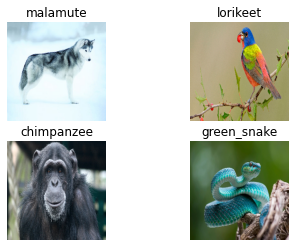

In [12]:
infer_real_images(func)

## Convert the model with TF-TRT

In [13]:
def trt_convert(input_path, output_path, input_shapes, explicit_batch=False):
    conv_params=trt.TrtConversionParams(
        precision_mode='FP16', minimum_segment_size=3,
        max_workspace_size_bytes=1<<30, maximum_cached_engines=1)
    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_path, conversion_params=conv_params,
        use_dynamic_shape=explicit_batch, dynamic_shape_profile_strategy='Optimal')

    converter.convert()
    def input_fn():
        for shapes in input_shapes:
            # return a list of input tensors
            yield [np.ones(shape=x).astype(np.float32) for x in shapes]

    converter.build(input_fn)
    converter.save(output_path)

Convert using implicit batch mode

In [14]:
trt_convert(input_path="resnet_v2_50_saved_model", output_path="resnet_v2_50_trt",
            input_shapes=[[input.shape]], 
            explicit_batch=False)

INFO:tensorflow:Linked TensorRT version: (7, 2, 1)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 1)
INFO:tensorflow:Assets written to: resnet_v2_50_trt/assets


### Load converted model and check difference

In [15]:
trt_func, _ = get_func_from_saved_model('resnet_v2_50_trt')

trt_output = trt_func(input)

In [16]:
diff = output['predictions'] - trt_output['predictions']
np.max(np.abs(diff.numpy()))

0.0041029155

Test the the converted model on real images

./data/img0.JPG - Predicted: [('n02110063', 'malamute', 0.72939986), ('n02110185', 'Siberian_husky', 0.2331302), ('n02109961', 'Eskimo_dog', 0.03746743)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.91486347), ('n01828970', 'bee_eater', 0.040196296), ('n01818515', 'macaw', 0.03155043)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.99837756), ('n02480495', 'orangutan', 0.0006608816), ('n02480855', 'gorilla', 0.00035651863)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.73841965), ('n01749939', 'green_mamba', 0.20505172), ('n01739381', 'vine_snake', 0.02566523)]


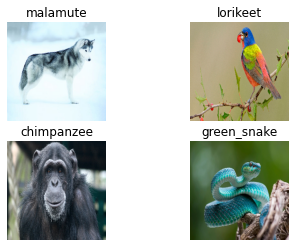

In [17]:
infer_real_images(trt_func)

## Benchmark converted model

In [18]:
res = predict_and_benchmark_throughput(input, trt_func)

Benchmarking with batch size 128
Steps 0-50 average: 24.1ms
Steps 50-100 average: 24.0ms
Steps 100-150 average: 24.0ms
Steps 150-200 average: 24.0ms
Steps 200-250 average: 24.0ms
Steps 250-300 average: 23.9ms
Steps 300-350 average: 23.9ms
Steps 350-400 average: 23.9ms
Steps 400-450 average: 23.9ms
Latency: 23.98+/-0.17ms
Throughput: 5338 images/s


### Check with different batch sizes

In [19]:
input1 = get_dummy_images(1)
res = predict_and_benchmark_throughput(input1, trt_func)

input8 = get_dummy_images(8)
res = predict_and_benchmark_throughput(input8, trt_func)

input32 = get_dummy_images(32)
res = predict_and_benchmark_throughput(input32, trt_func)

input64 = get_dummy_images(64)
res = predict_and_benchmark_throughput(input64, trt_func)

Generated input random images with shape (N, H, W, C) = (1, 224, 224, 3)
Benchmarking with batch size 1
Steps 0-50 average:  3.0ms
Steps 50-100 average:  3.0ms
Steps 100-150 average:  3.0ms
Steps 150-200 average:  3.0ms
Steps 200-250 average:  3.0ms
Steps 250-300 average:  3.0ms
Steps 300-350 average:  3.0ms
Steps 350-400 average:  3.0ms
Steps 400-450 average:  3.0ms
Latency:  2.99+/-0.16ms
Throughput: 334 images/s
Generated input random images with shape (N, H, W, C) = (8, 224, 224, 3)
Benchmarking with batch size 8
Steps 0-50 average:  3.9ms
Steps 50-100 average:  3.9ms
Steps 100-150 average:  3.9ms
Steps 150-200 average:  3.9ms
Steps 200-250 average:  3.9ms
Steps 250-300 average:  3.9ms
Steps 300-350 average:  3.9ms
Steps 350-400 average:  3.9ms
Steps 400-450 average:  3.9ms
Latency:  3.90+/-0.13ms
Throughput: 2053 images/s
Generated input random images with shape (N, H, W, C) = (32, 224, 224, 3)
Benchmarking with batch size 32
Steps 0-50 average:  8.0ms
Steps 50-100 average:  8.0ms

## Convert in dynamic mode
We convert for a single input shape first, just to test whether we get the same perf as in implicit batch mode.

In [20]:
trt_convert(input_path="resnet_v2_50_saved_model", output_path="resnet_v2_50_trt_ds",
            input_shapes=[[input.shape]], 
            explicit_batch=True)

INFO:tensorflow:Linked TensorRT version: (7, 2, 1)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 1)
INFO:tensorflow:Assets written to: resnet_v2_50_trt_ds/assets


In [21]:
trt_func_ds, _ = get_func_from_saved_model('resnet_v2_50_trt_ds')
trt_output = trt_func_ds(input)

In [22]:
diff = output['predictions'] - trt_output['predictions']
np.max(np.abs(diff.numpy()))

0.0041029155

./data/img0.JPG - Predicted: [('n02110063', 'malamute', 0.72939986), ('n02110185', 'Siberian_husky', 0.2331302), ('n02109961', 'Eskimo_dog', 0.03746743)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.91486347), ('n01828970', 'bee_eater', 0.040196296), ('n01818515', 'macaw', 0.03155043)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.99837756), ('n02480495', 'orangutan', 0.0006608816), ('n02480855', 'gorilla', 0.00035651863)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.73841965), ('n01749939', 'green_mamba', 0.20505172), ('n01739381', 'vine_snake', 0.02566523)]


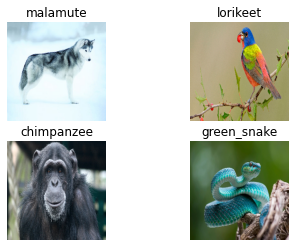

In [23]:
infer_real_images(trt_func_ds)

In [24]:
res = predict_and_benchmark_throughput(input, trt_func_ds)

Benchmarking with batch size 128
Steps 0-50 average: 24.0ms
Steps 50-100 average: 24.0ms
Steps 100-150 average: 24.0ms
Steps 150-200 average: 24.0ms
Steps 200-250 average: 24.0ms
Steps 250-300 average: 24.0ms
Steps 300-350 average: 24.0ms
Steps 350-400 average: 24.0ms
Steps 400-450 average: 24.0ms
Latency: 23.98+/-0.05ms
Throughput: 5337 images/s


## Convert with multiple profiles and benchmark
Here we show that we can have a single engine that is optimized to infer with various batch sizes: 1, 8, 32

In [25]:
img_shape = [224, 224, 3]
trt_convert(input_path="resnet_v2_50_saved_model", output_path="resnet_v2_50_trt_ds2",
            input_shapes=[[[1] + img_shape,], 
                          [[8] + img_shape,], 
                          [[32] + img_shape,],
                          [[64] + img_shape,],
                          [[128] + img_shape,]], 
            explicit_batch=True)

INFO:tensorflow:Linked TensorRT version: (7, 2, 1)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 1)
INFO:tensorflow:Assets written to: resnet_v2_50_trt_ds2/assets


In [26]:
trt_func_ds2, _ = get_func_from_saved_model('resnet_v2_50_trt_ds2')

### Batch size 128
Same results as before.

In [27]:
res = predict_and_benchmark_throughput(input, trt_func_ds2)

Benchmarking with batch size 128
Steps 0-50 average: 24.0ms
Steps 50-100 average: 24.0ms
Steps 100-150 average: 24.0ms
Steps 150-200 average: 24.0ms
Steps 200-250 average: 24.0ms
Steps 250-300 average: 24.0ms
Steps 300-350 average: 24.0ms
Steps 350-400 average: 24.0ms
Steps 400-450 average: 24.0ms
Latency: 24.00+/-0.06ms
Throughput: 5334 images/s


### Batch size 1
We compare the implicit batch engine to the dynamic shape engine. Note, that the implicit batch engine handles batch sizes 1..32, and it was optimized for N=32. The dynamic shape engine has a profile optimized for N=1, therefore it is faster (1.5 ms vs 2.2ms in implicit batch mode, measured on a V100 16GB card).

In [28]:
res = predict_and_benchmark_throughput(input1, trt_func_ds2)

Benchmarking with batch size 1
Steps 0-50 average:  1.6ms
Steps 50-100 average:  1.6ms
Steps 100-150 average:  1.6ms
Steps 150-200 average:  1.6ms
Steps 200-250 average:  1.6ms
Steps 250-300 average:  1.6ms
Steps 300-350 average:  1.6ms
Steps 350-400 average:  1.6ms
Steps 400-450 average:  1.6ms
Latency:  1.58+/-0.04ms
Throughput: 632 images/s


### Batch size 8
This is also faster with the dynamic shape engine 2.7 ms vs 3.1 in implicit batch mode.

In [29]:
res = predict_and_benchmark_throughput(input8, trt_func_ds2)

Benchmarking with batch size 8
Steps 0-50 average:  2.9ms
Steps 50-100 average:  3.0ms
Steps 100-150 average:  3.0ms
Steps 150-200 average:  2.9ms
Steps 200-250 average:  2.9ms
Steps 250-300 average:  3.0ms
Steps 300-350 average:  2.9ms
Steps 350-400 average:  2.9ms
Steps 400-450 average:  2.9ms
Latency:  2.95+/-0.13ms
Throughput: 2710 images/s


In [30]:
res = predict_and_benchmark_throughput(input32, trt_func_ds2)

Benchmarking with batch size 32
Steps 0-50 average:  7.5ms
Steps 50-100 average:  7.6ms
Steps 100-150 average:  7.7ms
Steps 150-200 average:  7.5ms
Steps 200-250 average:  7.5ms
Steps 250-300 average:  7.5ms
Steps 300-350 average:  7.5ms
Steps 350-400 average:  7.5ms
Steps 400-450 average:  7.5ms
Latency:  7.56+/-0.34ms
Throughput: 4231 images/s


In [31]:
res = predict_and_benchmark_throughput(input64, trt_func_ds2)


Benchmarking with batch size 64
Steps 0-50 average: 13.3ms
Steps 50-100 average: 13.3ms
Steps 100-150 average: 13.3ms
Steps 150-200 average: 13.3ms
Steps 200-250 average: 13.3ms
Steps 250-300 average: 13.3ms
Steps 300-350 average: 13.3ms
Steps 350-400 average: 13.3ms
Steps 400-450 average: 13.3ms
Latency: 13.31+/-0.07ms
Throughput: 4808 images/s


### Plots

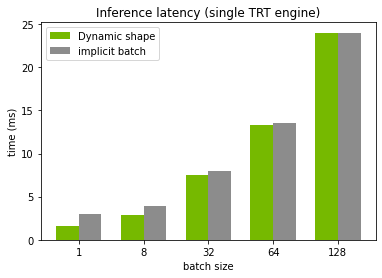

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

nvgreen = np.array((118, 185, 0)) / 255
medium_gray = np.array([140, 140, 140])/255

labels = ['1', '8', '32', '64', '128']

# Latency time for dynamic shae and implicit batch benchmarks
ds_time = [1.6, 2.9, 7.5, 13.3, 24.0]
impl_time = [2.99, 3.9, 7.96, 13.5, 23.98]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ds_time, width, color=nvgreen, label='Dynamic shape')
rects2 = ax.bar(x + width/2, impl_time, width, color=medium_gray, label='implicit batch')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (ms)')
ax.set_title('Inference latency (single TRT engine)')
ax.set_xticks(x)
ax.set_xlabel('batch size')
ax.set_xticklabels(labels)
ax.legend()